## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, I have worked on the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers
random.seed(42)

`1.` Now, reading in the `ab_data.csv` data. 

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


`2.` Number of rows in the dataset.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`3.` The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

`4.` The proportion of users converted.

In [5]:
(df.query('converted == "1"').user_id.count()/294478)*100

11.96591935560551

`5.` The number of times the `new_page` and `treatment` don't line up.

In [6]:
df_diffI = df[(df.group == 'treatment') & (df.landing_page == 'old_page')]
df_diffII = df[(df.group == 'control') & (df.landing_page == 'new_page')]
df_diffI.user_id.count() + df_diffII.user_id.count()


3893

`6.` Rows have missing values?

In [102]:
df.isnull().values.any()

False

`7.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  


In [7]:
df_nonmatching = pd.concat([df_diffI, df_diffII])
nonmatching_index = df_nonmatching.index
df2 = df
df2 = df2.drop(nonmatching_index)


In [8]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`8.` How many unique **user_id**s are in **df2**?

In [9]:
df2.user_id.nunique()


290584

`9.` There is one **user_id** repeated in **df2**.  What is it?

In [10]:
df2[df2.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`10.` What is the row information for the repeat **user_id**? 

In [11]:
df2.query('user_id == "773192"')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`11.` Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [12]:
df2.drop(labels=1899, axis=0, inplace=True)

In [13]:
df2.query('user_id == "773192"')

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`12.` What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.converted.mean()

0.11959708724499628

`13.` Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2.query('group == "control"').converted.mean()

0.1203863045004612

`14.` Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

`15.` What is the probability that an individual received the new page?

In [17]:
df2.query('landing_page == "new_page"').user_id.count()/len(df2)

0.5000619442226688


After looking at the probabilities, the control group converted at a higher rate that the treatment group and there is a difference of about 0.2% between them.
As the probability that an individual recieved a new page in around 0.5%, this shows that it is not possible for there to be a difference in conversion based on being given more opportunities to do so.

<a id='ab_test'></a>
### Part II - A/B Test


`1.` For now, let's consider we need to make the decision just based on all the data provided.  If we assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, the null and alternative hypotheses could be.

NULL

**$p_{new}$** - **$p_{old}$** <= 0

ALTERNATIVE

**$p_{new}$** - **$p_{old}$** > 0

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
p_new = df2.query('landing_page == "new_page"').converted.mean()
p_new

0.11880806551510564

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old = df2.query('landing_page == "old_page"').converted.mean()
p_old

0.1203863045004612

In [20]:
p_mean = np.mean([p_new, p_old])
p_mean

0.11959718500778342

In [21]:
p_diff = p_new - p_old
p_diff

-0.0015782389853555567

c. What is $n_{new}$?

In [22]:
n_new = df2.query('landing_page == "new_page"').user_id.count()
n_new

145310

d. What is $n_{old}$?

In [23]:
n_old = df2.query('landing_page == "old_page"').user_id.count()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [120]:
new_page_converted = np.random.binomial(1, p_mean, n_new)
new_page_converted.mean()

0.11805794508292616

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [121]:
old_page_converted = np.random.binomial(1, p_mean, n_old)
old_page_converted.mean()

0.11861035009705798

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [122]:
new_page_converted.mean() - old_page_converted.mean()

-0.00055240501413181264

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [25]:
p_diffs = []
for _ in range(10000):
    new_converted_simulation = np.random.binomial(n_new, p_mean, 10000)/n_new
    old_converted_simulation = np.random.binomial(n_old, p_mean, 10000)/n_old
    p_diffs = new_converted_simulation - old_converted_simulation

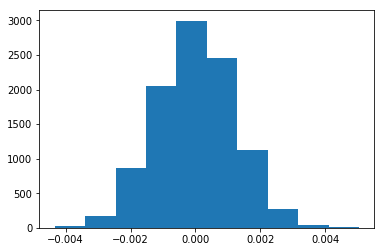

In [26]:
plt.hist(p_diffs);

i. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
p_diff = p_new - p_old
greater= [i for i in p_diffs if i > p_diff]
p_greater = len(greater)/len(p_diffs)
p_greater


0.902

we calculate that almost 90% of the population in our sample lies above the real difference.

The value which we have calculated is called p-value.

The p-value in this case means that the new page did not do better than the old page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm

convert_old = len(df2[(df2['landing_page']=='old_page')&(df2['converted']==1)])
convert_new = len(df2[(df2['landing_page']=='new_page')&(df2['converted']==1)])

n_old,  n_new  

(145274, 145310)

j. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [32]:
z_score, p_value = sm.stats.proportions_ztest(count=[convert_new, convert_old], 
                                              nobs=[n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

No, the p-value is approximately 19% which is the probability that this is due to random chance. So, we can't just reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic Regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [128]:
df3 = df2
df3['intercept']=1
df3['ab_page'] = pd.Series(np.zeros(len(df3)), index=df3.index)
index_change = df3[df3['group']=='treatment'].index
df3.set_value(index=index_change, col='ab_page', value=1)
df3[df3['group'] == 'treatment'].head()


,user_id,timestamp,group,landing_page,converted,intercept,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1.0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1.0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1.0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1.0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1.0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [129]:
import statsmodels.api as sm
logit_mod = sm.Logit(df3['converted'], df3[['intercept', 'ab_page']])
result = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [130]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 08 Apr 2018   Pseudo R-squ.:               8.077e-06
Time:                        13:03:56   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p-value is 0.90. The reason lies in the fact that in part ii, we were concerned with which page had a higher conversion rate, so a one-tailed test. However, in part iii, the nature of a regression test is not concerned with which had a positive or negative change, specifically. It is concerned with if the condition had any effect at all, so a two-tailed test.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Yes, there are disadvantages if we add extra features in our analysis which have small impact impact so these should not be taken into consideration and should only take those features which have large impact on our outcome.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [131]:
df_country = pd.read_csv('countries.csv')
df_country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [132]:
dummy = pd.get_dummies(data=df_country, columns=['country'])
df4 = dummy.merge(df3, on='user_id')

In [133]:
df4.head()

,user_id,country_CA,country_UK,country_US,timestamp,group,landing_page,converted,intercept,ab_page
0,834778,0,1,0,2017-01-14 23:08:43.304998,control,old_page,0,1,0.0
1,928468,0,0,1,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1.0
2,822059,0,1,0,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1.0
3,711597,0,1,0,2017-01-22 03:14:24.763511,control,old_page,0,1,0.0
4,710616,0,1,0,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1.0


In [134]:
logit = sm.Logit(df4['converted'], df4[['country_UK', 'country_US', 'intercept']])
result = logit.fit()


Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [135]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 08 Apr 2018   Pseudo R-squ.:               1.521e-05
Time:                        13:03:57   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
country_UK     0.0507      0.028      1.786      0.074      -0.005       0.106
country_US     0.0408      0.027      1.518      0.129      -0.012       0.093
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
==============================================================================
"""

Conclusion

Now as we see in this case the p-value for every feature has increased and the z-intercept for the intercept is also very large.

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by continuing on to the next module in the program.